In [30]:
import cv2
import os
from PIL import Image, ImageDraw
from tqdm import tqdm
import json
from matplotlib import pyplot as plt
from torchvision import transforms
from torchvision.utils import draw_bounding_boxes
from torchvision.ops import box_convert
import numpy as np
import torch

## 备注

2023 年 4 月 7 日，已将 cropped 文件夹改为原文件夹，原文件夹改为 raw

In [9]:
def crop(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    thresh, gray = cv2.threshold(
        img, 200, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    coords = cv2.findNonZero(gray)
    x, y, w, h = cv2.boundingRect(coords)
    left, top, right, bottom = x - 3, y - 3, x + w + 3, y + h + 3
    rect = img[top:bottom, left:right]
    cv2.imwrite(img_path.replace("pdf_to_img", "croped_img"), rect)
    return left, top, right, bottom

In [3]:
dataset_dir = '/Volumes/Disk/Dataset/tsr/SciTSR'
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

In [5]:
if not os.path.exists(os.path.join(train_dir, 'croped_img')):
    os.mkdir(os.path.join(train_dir, 'croped_img'))
if not os.path.exists(os.path.join(test_dir, 'croped_img')):
    os.mkdir(os.path.join(test_dir, 'croped_img'))

In [8]:
if not os.path.exists(os.path.join(train_dir, 'croped_chunk')):
    os.mkdir(os.path.join(train_dir, 'croped_chunk'))
if not os.path.exists(os.path.join(test_dir, 'croped_chunk')):
    os.mkdir(os.path.join(test_dir, 'croped_chunk'))

In [11]:
def coordinate_transform(x, y, left, top):
    x_ratio = 1241/595
    y_ratio = 1754/842
    new_x = x*x_ratio - left
    new_y = 1754- y*y_ratio - top
    return new_x, new_y

In [29]:
for img in tqdm(os.listdir(os.path.join(train_dir, 'pdf_to_img'))):
    l, t, r, b = crop(os.path.join(train_dir, 'pdf_to_img', img))
    table_name = img.replace('.'+img.split('.')[-1], '')
    with open(os.path.join(train_dir, 'chunk', table_name+'.chunk'), 'r') as f:
        chunk = json.load(f)
        cells = []
        for cell in chunk['chunks']:
            x_min, x_max, y_min, y_max = cell['pos']
            new_x_min, new_y_min = coordinate_transform(x_min, y_min, l, t)
            new_x_max, new_y_max = coordinate_transform(x_max, y_max, l, t)
            cells.append({
                'pos': [new_x_min, new_y_min, new_x_max, new_y_max],
                'text': cell['text']
            })
        new_chunk = {
            'chunks': cells,
        }
        with open(os.path.join(train_dir, 'croped_chunk', table_name+'.chunk'), 'w') as f:
            json.dump(new_chunk, f)



100%|██████████| 12000/12000 [16:02<00:00, 12.47it/s] 


In [32]:
for img in tqdm(os.listdir(os.path.join(test_dir, 'pdf_to_img'))):
    l, t, r, b = crop(os.path.join(test_dir, 'pdf_to_img', img))
    table_name = img.replace('.'+img.split('.')[-1], '')
    with open(os.path.join(test_dir, 'chunk', table_name+'.chunk'), 'r') as f:
        chunk = json.load(f)
        cells = []
        for cell in chunk['chunks']:
            x_min, x_max, y_min, y_max = cell['pos']
            new_x_min, new_y_min = coordinate_transform(x_min, y_min, l, t)
            new_x_max, new_y_max = coordinate_transform(x_max, y_max, l, t)
            cells.append({
                'pos': [new_x_min, new_y_min, new_x_max, new_y_max],
                'text': cell['text']
            })
        new_chunk = {
            'chunks': cells,
        }
        with open(os.path.join(test_dir, 'croped_chunk', table_name+'.chunk'), 'w') as f:
            json.dump(new_chunk, f)

100%|██████████| 3000/3000 [06:07<00:00,  8.15it/s]


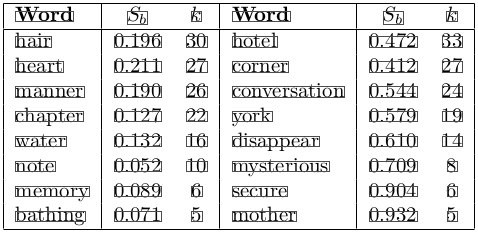

In [59]:
# load and draw the image
img_path = os.path.join(train_dir, 'raw_img', '1504.02162v2.2.png')
chunk_path = os.path.join(train_dir, 'chunk', '1504.02162v2.2.chunk')
img = Image.open(img_path)

# load the coordinates
with open(chunk_path, 'r') as f:
    chunk = json.load(f)
    cells = chunk['chunks']

# draw the image
for cell in cells:
    x_min, x_max, y_min, y_max = cell['pos']
    if y_min > y_max:
        y_min, y_max = y_max, y_min
    draw = ImageDraw.Draw(img)
    draw.rectangle(((x_min, y_min), (x_max, y_max)), outline='red')

# show the image
img

In [ ]:
# load and draw the image
img_path = os.path.join(train_dir, 'img', '1504.02162v2.2.png')
chunk_path = os.path.join(train_dir, 'chunk', '1504.02162v2.2.chunk')
img = Image.open(img_path)

# load the coordinates
with open(chunk_path, 'r') as f:
    chunk = json.load(f)
    cells = chunk['chunks']

# draw the image
for cell in cells:
    x_min, y_min, x_max, y_max = cell['pos']
    draw = ImageDraw.Draw(img)
    draw.rectangle(((x_min, y_min), (x_max, y_max)), outline='red')

# show the image
img

In [44]:
def get_transform(img_height, img_width):
    img_transforms = []

    # 预设的固定图像大小，取出短边和长边
    min_length = 512
    max_length = 512

    # 取出图像的短边和长边
    img_min_length = min(img_height, img_width)
    img_max_length = max(img_height, img_width)

    # 计算短边和长边的缩放比例
    img_scale = float(min_length) / float(img_min_length)

    if int(img_scale * img_max_length) > max_length:
        img_scale = float(max_length) / float(img_max_length)

    # 缩放图像
    scaled_img_height = int(img_scale * img_height)
    scaled_img_width = int(img_scale * img_width)

    padding_left, padding_top = (max_length - scaled_img_width) // 2, (
        max_length - scaled_img_height
    ) // 2
    padding_right, padding_bottom = (
        max_length - scaled_img_width - padding_left,
        max_length - scaled_img_height - padding_top,
    )

    # 创建transforms
    # Image.BICUBIC 图像双三次插值
    img_transforms.append(
        transforms.Resize((scaled_img_height, scaled_img_width), Image.BICUBIC)
    )
    # Image.PAD 填充图像
    img_transforms.append(
        transforms.Pad(
            (padding_left, padding_top, padding_right, padding_bottom),
            padding_mode="edge",
        )
    )
    # Image.ToTensor 将图像转换为tensor
    img_transforms.append(transforms.ToTensor())
    # Image.Normalize 对图像进行归一化
    img_transforms.append(transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))

    return (
        img_scale,
        padding_left,
        padding_top,
        transforms.Compose(img_transforms),
    )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


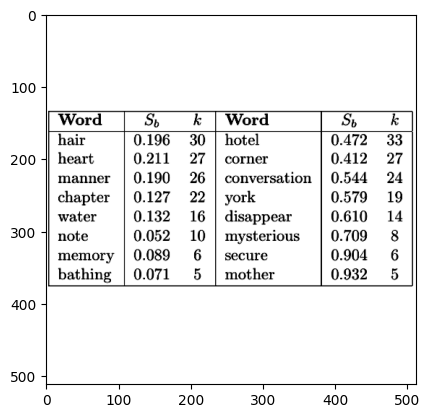

In [56]:
img_path = os.path.join(train_dir, 'img', '1504.02162v2.2.png')
chunk_path = os.path.join(train_dir, 'chunk', '1504.02162v2.2.chunk')
img = Image.open(img_path).convert("RGB")
img_width, img_height = img.size

scale, padding_left, padding_top, img_transform = get_transform(img_height, img_width)
scaled_img = img_transform(img)

# show image
plt.imshow(scaled_img.permute(1, 2, 0))

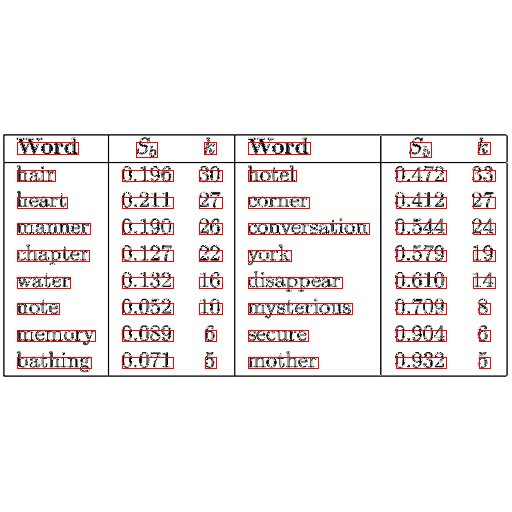

In [58]:
# scaled the bounding box
with open(chunk_path, 'r') as f:
    chunk = json.load(f)
    cells = chunk['chunks']

# convert scaled_img to PIL image
uint_img = (scaled_img * 255).byte()
uint_img = transforms.ToPILImage()(scaled_img)

boxes = []

for cell in cells:
    x_min, x_max, y_min, y_max = cell['pos']
    x_min = int(x_min * scale + padding_left)
    y_min = int(y_min * scale + padding_top)
    x_max = int(x_max * scale + padding_left)
    y_max = int(y_max * scale + padding_top)

    draw = ImageDraw.Draw(uint_img)
    draw.rectangle(((x_min, y_min), (x_max, y_max)), outline='red')


uint_img
